# Results analysis

_Adapted from Sam Schmidt example notebook (https://github.com/LSSTDESC/rail_tpz) and Demo: RAIL Evaluation notebook (https://rail-hub.readthedocs.io/projects/rail-notebooks/en/latest/rendered/evaluation_examples/Evaluation_Demo.html)._

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rail
import qp
from rail.core.data import TableHandle, PqHandle, ModelHandle, QPHandle, DataHandle, Hdf5Handle
from rail.core.data import TableHandle
from rail.core.stage import RailStage

In [2]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

In [3]:
from qp.ensemble import Ensemble
from matplotlib import gridspec
from qp import interp
from qp.metrics.pit import PIT
from rail.evaluation.metrics.cdeloss import *
from rail.evaluation.evaluator import OldEvaluator
from utils import plot_pit_qq, ks_plot
import os
from rail.estimation.algos.naive_stack import NaiveStackSummarizer
from scipy.interpolate import UnivariateSpline

%matplotlib inline
%reload_ext autoreload
%autoreload 

### 1. Reading the data

In [4]:
tree_strategy = '_skl_'
test = 'test3_'
run = 'run3_'
maglim = 'mag_lim_24_1'

In [20]:
ztrue_file='/home/andreia.dourado/ic-photoz/andreia_dourado/test_data_mag_lim_24_1.hdf5'

In [21]:
ztrue_data = DS.read_file('ztrue_data', TableHandle, ztrue_file)

In [22]:
pdfs_file="/home/andreia.dourado/ic-photoz/andreia_dourado/output"+tree_strategy+test+run+maglim+".hdf5"

In [23]:
tpzdata = DS.read_file('pdfs_data', QPHandle, pdfs_file)

In [91]:
ztrue = ztrue_data()['redshift']
zgrid = tpzdata().metadata()['xvals'].ravel()
photoz_mode = tpzdata().mode(grid=zgrid)

In [28]:
truth = DS.add_data('truth', ztrue_data(), TableHandle)
ensemble = DS.add_data('ensemble', tpzdata(), QPHandle)

In [29]:
DS

DataStore
{  ztrue_data:<class 'rail.core.data.TableHandle'> /home/andreia.dourado/ic-photoz/andreia_dourado/test_data_mag_lim_24_1.hdf5, (wd)
  pdfs_data:<class 'rail.core.data.QPHandle'> /home/andreia.dourado/ic-photoz/andreia_dourado/output_skl_test3_run3_mag_lim_24_1.hdf5, (wd)
  truth:<class 'rail.core.data.TableHandle'> None, (d)
  ensemble:<class 'rail.core.data.QPHandle'> None, (d)
  input:<class 'rail.core.data.QPHandle'> None, (d)
}

### 2. Point estimates

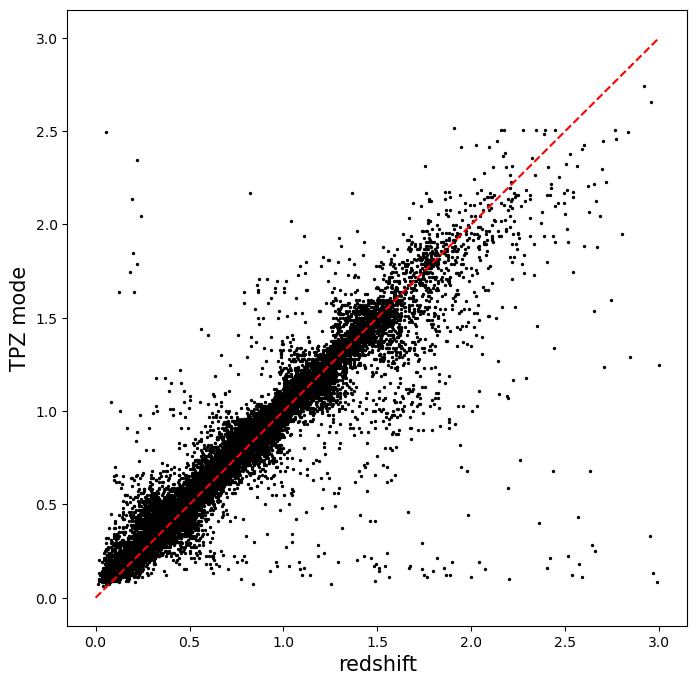

In [30]:
plt.figure(figsize=(8,8))
plt.scatter(ztrue,photoz_mode, s=2,c='k')
plt.plot([0,3],[0,3],'r--')
plt.xlabel("redshift", fontsize=15)
plt.ylabel("TPZ mode", fontsize=15)
plt.savefig('point_estimate'+tree_strategy+test+run+maglim+'.png')

### 2. A individual redshift PDF

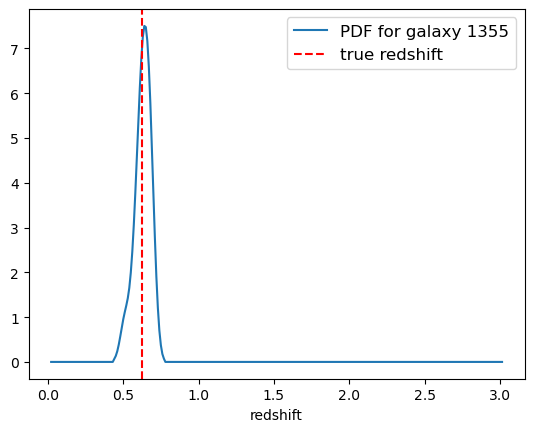

In [31]:
which=1355
fig, axs = plt.subplots()
tpzdata().plot_native(key=which,axes=axs, label=f"PDF for galaxy {which}")
axs.axvline(ztrue[which],c='r',ls='--', label="true redshift")
plt.legend(loc='upper right', fontsize=12)
axs.set_xlabel("redshift")
plt.savefig('example_pdf'+tree_strategy+test+run+maglim+'.png')

### 3. Basic metrics

In [ ]:
def plot_metrics(zspec,
                 zphot,
                 maximum,
                 path_to_save='',
                 title=None,
                 initial=0):
    
    '''
    Function to plot Bias, Sigma_68, Out2σ, Out3σ given a spectroscopic and photometric redshift. 
    
    Args:
    
    zspec: Numpy array with the spectroscopic redshift.
    
    zphot: Numpy array with the photometric redshifts calculated. Same size as zspec.
    
    maximum: Float that indicates the redshift max of the plots.
    
    Kwargs:
    
    initial: Float that indicates the redshift min of the plots.
    
    
    
    '''
    
    
    
    
    
    
    bins = np.arange(initial, maximum, 0.1)
    points = bins+0.05
    fraction_outliers = []
    sigma68z = []
    sigmaz=[]
    meanz = []
    outliers_2 = []

    for index in range(len(bins) - 1):
        bin_lower = bins[index]
        bin_upper = bins[index + 1]
        
    
        values_r = zphot[(zphot >= bin_lower) & (zphot <= bin_upper)]
        values_s = zspec[(zphot >= bin_lower) & (zphot <= bin_upper)]
        
        

        deltabias = (values_r - values_s)
        mean_bias = np.mean(deltabias)  # Mean bias for each bin
        meanz.append(mean_bias)
        
        
    
        s = np.sort(np.abs(deltabias/(1+values_s)))# Standard deviation (sigma) for each bin
        #print(s)
        sigma68 = s[int(len(s)*0.68)]
        sigma68z.append(sigma68)
        
        
        
        sigma = (np.sum((values_r-values_s-mean_bias)**2)/len(values_r))**0.5
        sigmaz.append(sigma)
    
        # Calculate the fraction of outliers outside 3 sigma
        outliers = deltabias[np.abs(deltabias-mean_bias) > 3 * sigma]
        fraction_outlier = len(outliers) / len(deltabias)
        fraction_outliers.append(fraction_outlier)
        
        
    
        #2 sigma
        outliers2 = deltabias[np.abs(deltabias-mean_bias) > 2 * sigma]
        fraction_outlier2 = len(outliers2) / len(deltabias)
        outliers_2.append(fraction_outlier2)



    fig, axes = plt.subplots(4, 1, figsize=(8, 14), sharex=True)
    plt.subplots_adjust(hspace=0.001) 

    axes[1]
    x_lim = (0, np.max(bins))

    # Subplot 1: Mean Bias
    axes[0].plot(points[:-1], meanz, 'bo-')
    axes[0].axhline(0, color='black', linestyle='--')
    axes[0].set_ylabel(r'$\Delta z$', fontsize=20)
    axes[0].set_xlim(x_lim)
    axes[0].set_ylim(-0.05,0.05)
    axes[0].tick_params(axis='both', labelsize=14)
    axes[0].grid(True)

    # Subplot 2: Sigma 68
    axes[1].plot(points[:-1], sigma68z, 'go-')
    axes[1].set_ylabel(r'$\sigma_{68}$', fontsize=20)
    axes[1].set_xlim(x_lim)
    axes[1].axhline(0.12, color='black', linestyle='--')
    axes[1].set_ylim(0,max(sigmaz)+0.01)
    axes[1].set_ylim(0, 0.03)
    axes[1].set_yticks(np.arange(0, 0.5, 0.05))
    axes[1].tick_params(axis='both', labelsize=14)
    axes[1].set_xlim(x_lim)
    axes[1].axhline(0.12, color='black', linestyle='--')
    axes[1].set_ylim(0,max(sigmaz)+0.01)
    axes[1].set_ylim(0, 0.03)
    axes[1].set_yticks(np.arange(0, 0.5, 0.05))
    axes[1].tick_params(axis='both', labelsize=14)
    axes[1].grid(True)


    # Subplot3: 2_outliers
    axes[2].plot(points[:-1],outliers_2,'o-',color='darkorange')
    #axes[2].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[2].set_ylabel('out$_{2σ}$', fontsize=20)
    axes[2].set_xlim(x_lim)
    axes[2].set_ylim(0,0.12)
    axes[2].axhline(0.1, color='black', linestyle='--')
    axes[2].tick_params(axis='both', labelsize=14)
    axes[2].grid(True)
    #axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Subplot 4: 3_outliers
    axes[3].plot(points[:-1], fraction_outliers, 'ro-')
    axes[3].set_xlabel(r'$Z_{spec}$', fontsize=20)
    axes[3].set_ylabel('out$_{3σ}$', fontsize=20)
    axes[3].set_xlim(x_lim)
    axes[3].set_ylim(0,0.12)
    axes[3].axhline(0.1, color='black', linestyle='--')
    axes[3].tick_params(axis='both', labelsize=14)
    axes[3].grid(True)
   

    plt.suptitle(title)
    plt.xlim(0,3)
    plt.tight_layout()

    #if path_to_save != '':
    plt.savefig('metrics'+tree_strategy+test+run+maglim+'.png')
    

    #plt.show()

In [ ]:
z_mode= np.squeeze(photoz_mode)
plot_metrics(ztrue,z_mode,max(z_mode)-0.2,initial=0)

#### PIT QQ

In [72]:
pitobj = PIT(tpzdata(), ztrue)
quant_ens = pitobj.pit
metamets = pitobj.calculate_pit_meta_metrics()

/opt/conda/envs/[env]/lib/python3.12/site-packages/qp/metrics/array_metrics.py:27: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  return stats.anderson_ksamp([p_random_variables, q_random_variables], **kwargs)


In [73]:
metamets

{'ad': Anderson_ksampResult(statistic=838.5748713978703, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001),
 'cvm': CramerVonMisesResult(statistic=249.44951029757465, pvalue=9.93495098411401e-08),
 'ks': KstestResult(statistic=0.14039190490028242, pvalue=0.0, statistic_location=0.5449653774113146, statistic_sign=1),
 'outlier_rate': 0.03169433683770785}

In [74]:
pit_vals = np.array(pitobj.pit_samps)
pit_vals

array([0.33505001, 0.8472681 , 0.87685375, ..., 0.40875831, 0.44527156,
       0.56205843])

In [75]:
pit_out_rate = metamets['outlier_rate']
print(f"PIT outlier rate of this sample: {pit_out_rate:.6f}")
pit_out_rate = pitobj.evaluate_PIT_outlier_rate()
print(f"PIT outlier rate of this sample: {pit_out_rate:.6f}")

PIT outlier rate of this sample: 0.031694
PIT outlier rate of this sample: 0.031694


In [76]:
pdfs = tpzdata.data.objdata()['yvals']

'plot_pit_qq_TPZ.png'

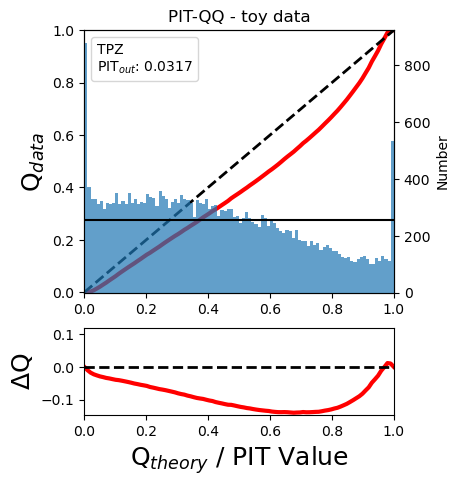

In [77]:
plot_pit_qq(pdfs, zgrid, ztrue, title="PIT-QQ - toy data", code="TPZ",
                pit_out_rate=pit_out_rate, savefig=True)

### N(z)

In [ ]:
stacker = NaiveStackSummarizer.make_stage(zmin=0.0, zmax=max(photoz_mode), nzbins=301, nsamples=20, hdf5_groupname=None, output="Naive_samples"+tree_strategy+test+run+maglim+".hdf5", single_NZ="NaiveStack_NZ"+tree_strategy+test+run+maglim+".hdf5")

In [ ]:
naive_results = stacker.summarize(tpzdata)

In [ ]:
newens = naive_results.data

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.title('Histogram of the True redshift', fontsize = 20)
plt.xlabel('z', fontsize = 17)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5) 
z = plt.hist(ztrue, bins=zgrid, density=True, color = 'dodgerblue')
zmode = plt.hist(photoz_mode, bins=zgrid, density=True, color = 'orange')

In [ ]:
cs = UnivariateSpline(zgrid[:-1], z[0])
cs.set_smoothing_factor(1)

In [ ]:
varinf_nz = qp.read("NaiveStack_NZ"+tree_strategy+test+run+maglim+".hdf5")
varinf_nz.plot_native(xlim=(0,3), color = 'orange', label = 'z$_{phot TPZ}$ PDF')
plt.plot(zgrid,cs(zgrid), color = 'dodgerblue', label = 'z$_{spec}$ PDF')
#plt.plot(zgrid,tpz['data']['yvals'][0], color = 'red', label = 'z$_{photo TPZ}$ PDF')
plt.legend(fontsize = 15)
plt.savefig('n(z)'+tree_strategy+test+run+maglim+'_.png')

#### Point Evaluation

In [45]:
from rail.evaluation.point_to_point_evaluator import PointToPointEvaluator

In [50]:
ztrue_file_new='/home/andreia.dourado/ic-photoz/andreia_dourado/test_set_photometry_24_1.hdf5'

In [62]:
ztrue_photometry = DS.read_file('ztrue_photometry', TableHandle, ztrue_file_new)
ztrue_photometry()['photometry']['redshift']

array([0.910263, 1.66757 , 1.19443 , ..., 0.116998, 0.995877, 0.867016])

In [63]:
zmode = photoz_mode.squeeze()
zmode

array([0.92924574, 1.53749996, 1.12867335, ..., 0.1215639 , 1.00901678,
       0.85944607])

In [64]:
stage_dict = dict(
    metrics=['point_stats_ez', 'point_stats_iqr', 'point_bias', 'point_outlier_rate', 'point_stats_sigma_mad'],
    _random_state=None,
    hdf5_groupname= 'photometry',
    point_estimate_key='zmode',
    chunk_size=10000,
    metric_config={
        'point_stats_iqr':{'tdigest_compression': 100},
    }
)
ptp_stage = PointToPointEvaluator.make_stage(name='point_to_point', **stage_dict)
ptp_stage_single = PointToPointEvaluator.make_stage(name='point_to_point', force_exact=True, **stage_dict)

In [65]:
import tables_io

In [66]:
ptp_results_single = ptp_stage_single.evaluate(ensemble, ztrue_photometry)
results_summary_single = tables_io.convertObj(ptp_stage_single.get_handle('summary')(), tables_io.types.PD_DATAFRAME)
results_summary_single

Requested metrics: ['point_stats_ez', 'point_stats_iqr', 'point_bias', 'point_outlier_rate', 'point_stats_sigma_mad']
Inserting handle into data store.  output_point_to_point: inprogress_output_point_to_point.hdf5, point_to_point
Inserting handle into data store.  summary_point_to_point: inprogress_summary_point_to_point.hdf5, point_to_point
Inserting handle into data store.  single_distribution_summary_point_to_point: inprogress_single_distribution_summary_point_to_point.hdf5, point_to_point


NOTE/WARNING: Expected output file single_distribution_summary_point_to_point.hdf5 was not generated.


,point_stats_iqr,point_bias,point_outlier_rate,point_stats_sigma_mad
0,0.028561,0.009719,0.085318,0.02843


In [69]:
ez = (zmode-ztrue)/(1+ztrue)
rms = np.sqrt(np.mean((ez-np.mean(ez))**2))

In [89]:
print(f'RMS LSST requirement: 0.05 (goal: 0.02)')
print(f'RMS: {np.round(rms,4)} ')
print(f'Bias LSST requirement: 0.003')
print(f'Bias: {np.round(ptp_stage_single.get_handle('summary')()['point_bias'][0],4)}')
print(f'Fraction Outliers LSST requirement: 0.1')
print(f'Fraction Outliters: {np.round(ptp_stage_single.get_handle('summary')()['point_outlier_rate'][0],4)}')

RMS LSST requirement: 0.05 (goal: 0.02)
RMS: 0.0708 
Bias LSST requirement: 0.003
Bias: 0.0097
Fraction Outliers LSST requirement: 0.1
Fraction Outliters: 0.0853


Text(0.5, 0, 'zphot')

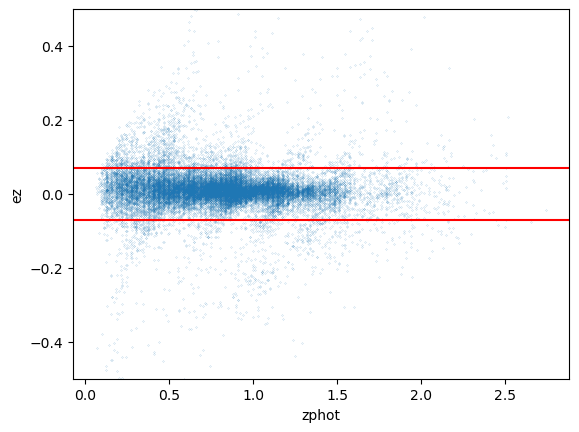

In [78]:
plt.scatter(zmode,ez,s=0.01)
plt.axhline(rms,color='red')
plt.axhline(-rms,color='red')
plt.ylim(-0.5,0.5)
plt.ylabel('ez')
plt.xlabel('zphot')

Text(0.5, 0, 'zphot')

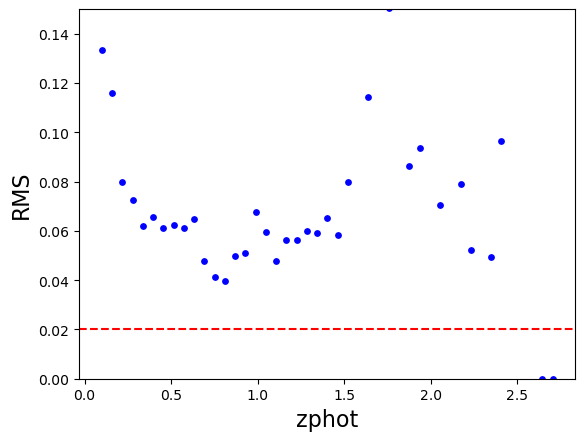

In [85]:
z_bins = np.linspace(0.1,3,50)
rms_all=[]

for i in range(len(z_bins[:-1])):
    mask = (zmode>z_bins[i])&(zmode<z_bins[i+1])
    
    delta = zmode[mask] - ztrue[mask]
    ez_i = (delta)/(1+ztrue[mask])
    
    rms_i = np.sqrt(np.mean((ez_i-np.mean(ez_i))**2))
    rms_all.append(rms_i)

plt.scatter(z_bins[:-1],rms_all,s=15,color='blue')
plt.ylim(0,0.15)
plt.axhline(0.02,color='red',ls='--')
plt.ylabel('RMS',fontsize=16)
plt.xlabel('zphot',fontsize=16)

Text(0, 0.5, 'zphot')

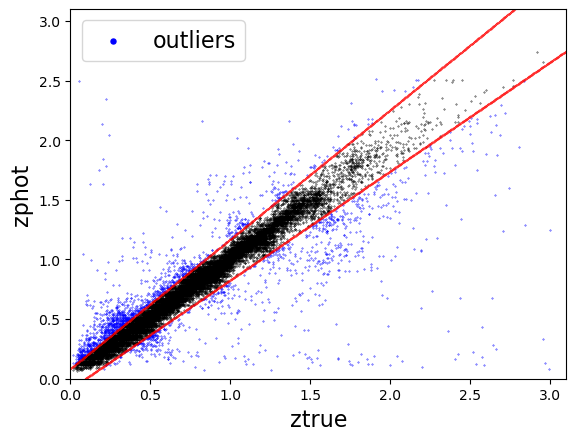

In [84]:
cutcriterion_all = np.maximum(0.06, 3*ptp_stage_single.get_handle('summary')()['point_stats_iqr'][0])
mask = (np.fabs(ez) > np.fabs(cutcriterion_all))
points=np.linspace(0,3.3,1000)

plt.scatter(ztrue[mask],zmode[mask],s=0.1,color='blue')
plt.scatter([],[],color='blue',s=13,label='outliers')
plt.scatter(ztrue[~mask],zmode[~mask],s=0.1,color='black')
plt.scatter(points,points+3*ptp_stage_single.get_handle('summary')()['point_stats_iqr'][0]*(1+points),color='red',s=0.1)
plt.scatter(points,points-3*ptp_stage_single.get_handle('summary')()['point_stats_iqr'][0]*(1+points),color='red',s=0.1)
plt.xlim(0,3.1)
plt.ylim(0,3.1)
plt.legend(fontsize=16,loc=2)
plt.xlabel('ztrue',fontsize=16)
plt.ylabel('zphot',fontsize=16)
#plt.title(f'Train {name_train}_i{mag_train} | Test {name_test}_i{mag_test}')
#plt.savefig(f'/home/iago/ic_cosmo/plots/new_scatter_Fzb_Train{train}_i{mag_t